In [215]:
import numpy as np
from scipy.spatial import distance
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import math


np.seterr(divide='ignore', invalid='ignore')

NOISE = 1e-20

In [216]:
def point_in_hull(point, hull):
    '''
    Check if a point is inside the convex hull.
    '''
    return all((np.dot(eq[:-1], point) + eq[-1] <= 0) for eq in hull.equations)

def degree_of_convexity_cluster(cluster_points):
    '''
    Build the convex hull around cluster. 
    Find the number of points in the hull. 
    Divide the number of points in the class 
    by the number of points inside the hull
    '''
    if len(cluster_points) < 4:
        return 1
    else:
        hull = ConvexHull(cluster_points)
        in_hull = [p for p in cluster_points if point_in_hull(p, hull)]
        return len(in_hull) / (len(cluster_points) + 1)

def degree_of_convexity(arrays):
    '''Compute the degree of convexity for the given array or arrays'''
    convexity_list = []
    for arr in arrays:
        labels = np.unique(arr)  # Get unique labels
        convexities = [degree_of_convexity_cluster(np.argwhere(arr == label)) for label in labels]
        weights = [np.sum(arr == label) for label in labels]
        convexity = np.average(convexities, weights=weights)
        convexity_list.append(convexity)
    return convexity_list

# Given arrays
arrays = np.array([[[2, 2, 2, 0],
                    [1, 0, 0, 2],
                    [0, 2, 2, 1],
                    [0, 1, 1, 2]],

                   [[1, 2, 1, 0],
                    [2, 0, 2, 2],
                    [2, 0, 1, 0],
                    [2, 1, 1, 2]],

                   [[1, 2, 2, 2],
                    [1, 2, 1, 1],
                    [1, 2, 0, 0],
                    [2, 2, 0, 1]],

                   [[0, 1, 2, 0],
                    [1, 2, 1, 1],
                    [0, 2, 2, 1],
                    [0, 1, 2, 1]],

                   [[2, 1, 2, 2],
                    [0, 2, 2, 1],
                    [0, 2, 0, 0],
                    [0, 2, 1, 2]]])

convexities = degree_of_convexity(arrays)
print("Degrees of Convexity:", convexities)

Degrees of Convexity: [0.8432291666666667, 0.8432291666666667, 0.8381696428571428, 0.7885416666666667, 0.8402777777777777]


In [217]:
def calculate_upper_bound(N, shape):
    total_elements = np.prod(shape)
    return min(N**total_elements, N ** max(0, total_elements - N + 1))


In [218]:
def generate_lexicons(N, shape, n):
    total_elements = np.prod(shape)
    upper_bound = min(N**total_elements, N ** max(0, total_elements - N + 1))
    lexicons = set()

    while len(lexicons) < min(n, upper_bound):
        lexicon = tuple(map(tuple, np.random.randint(0, N, shape)))
        lexicons.add(lexicon)

    return np.array([list(lexicon) for lexicon in lexicons])

In [219]:
generate_lexicons(9, (3, 3), 100)

array([[[4, 3, 1],
        [4, 5, 4],
        [8, 8, 4]],

       [[3, 4, 6],
        [1, 7, 4],
        [6, 8, 6]],

       [[3, 1, 4],
        [6, 4, 3],
        [5, 7, 2]],

       [[6, 0, 5],
        [8, 0, 7],
        [1, 6, 7]],

       [[2, 3, 7],
        [4, 4, 1],
        [1, 5, 0]],

       [[5, 4, 3],
        [7, 8, 3],
        [5, 8, 4]],

       [[7, 8, 1],
        [7, 2, 7],
        [7, 1, 0]],

       [[0, 5, 0],
        [0, 2, 3],
        [3, 3, 6]],

       [[5, 8, 6],
        [1, 1, 6],
        [7, 7, 5]]])

In [220]:
# def generate_lexicons(N, shape, n):
#     # sample a shape numpy array with N integers n times
#     return np.random.randint(0, N, (n, *shape))

In [221]:
class BaseRSA:
    def __init__(self, alpha, prior):
        self.alpha = alpha
        self.prior = prior

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)
        
    @staticmethod
    def normalize(vals):
        return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))
        
    @staticmethod
    def binary_language(L):
        max_labels = np.max([np.max(subarray) for subarray in L]) + 1
        binary_arrays = []
        for subarray in L:
            x = max_labels
            y = np.prod(subarray.shape)
            binary_array = np.zeros((x, y), dtype=np.uint8)
            for i, row in enumerate(subarray):
                for j, val in enumerate(row):
                    binary_array[val, i * subarray.shape[1] + j] = 1
            binary_arrays.append(binary_array)
        return np.array(binary_arrays)
    
    @staticmethod
    def informativeness(L):
        inf_arrays = []
        for subarray in L:
            unique_labels = np.unique(subarray)
            inf_p = np.zeros((len(unique_labels), subarray.size))
            for c in unique_labels:
                coords = np.argwhere(subarray == c)
                for i, m in enumerate(list(np.ndindex(subarray.shape))):
                    for n in coords:
                        inf_p[c, i] += distance.euclidean(m, n)
            inf_arrays.append(inf_p)
        return np.array(inf_arrays)

    def L_0(self, L):
        '''Literal listener'''
        binary_lang = self.binary_language(L)
        return self.normalize(binary_lang * self.prior * self.informativeness(L))
    
    def S_p(self, L):
        return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)))))
    
    def L_p(self, L):
        return self.normalize((self.S_p(L).transpose(0, 2, 1) * self.prior * self.informativeness(L)))


In [222]:
a = BaseRSA(1, np.ones(4) / 4)

In [223]:
L = generate_lexicons(2, (2, 2), 2)
L

array([[[0, 0],
        [1, 1]],

       [[1, 0],
        [1, 1]]])

In [224]:
a.informativeness(L)[1]

array([[1.        , 0.        , 1.41421356, 1.        ],
       [2.41421356, 3.41421356, 2.        , 2.41421356]])

In [225]:
a.L_p(L)

array([[[0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.5       ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.35355339, 0.        , 0.29289322, 0.35355339]]])

In [226]:
import numpy as np
from scipy.spatial import distance

class BaseRSA:
    def __init__(self, alpha, prior):
        self.alpha = alpha
        self.prior = prior

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)
        
    @staticmethod
    def binary_language(L):
        max_labels = np.max([np.max(subarray) for subarray in L]) + 1
        binary_arrays = []
        for subarray in L:
            x = max_labels
            y = np.prod(subarray.shape)
            binary_array = np.zeros((x, y), dtype=np.uint8)
            for i, row in enumerate(subarray):
                for j, val in enumerate(row):
                    binary_array[val, i * subarray.shape[1] + j] = 1
            binary_arrays.append(binary_array)
        return np.array(binary_arrays)
    
    @staticmethod
    def normalize(vals):
        return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))
    
    @staticmethod
    def informativeness(L):
        inf_arrays = []
        for subarray in L:
            inf_p = np.zeros(subarray.shape)
            unique_labels = np.unique(subarray)
            for c in unique_labels:
                coords = np.argwhere(subarray == c)
                for m in list(np.ndindex(subarray.shape)):
                    for n in coords:
                        inf_p[m[0], m[1]] += distance.euclidean(m, n)
            inf_arrays.append(inf_p.flatten())
        return np.expand_dims(np.array(inf_arrays), axis=1)

    def L_0(self, L):
        '''Literal listener'''
        return self.normalize(self.binary_language(L) * self.informativeness(L) * self.prior) 
    # 
    
    def S_p(self, L):
        return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)))))
    
    def L_p(self, L):
        return self.normalize((self.S_p(L).transpose(0, 2, 1) * self.prior))


In [227]:
L = generate_lexicons(2, (2, 2), 5)

In [228]:
L

array([[[1, 1],
        [1, 1]],

       [[0, 1],
        [1, 0]],

       [[1, 0],
        [0, 0]],

       [[1, 0],
        [1, 0]],

       [[0, 0],
        [1, 0]]])

In [229]:
rsa = BaseRSA(10, np.ones(4) / 4)

In [230]:
rsa.L_p(L)

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.25      , 0.25      , 0.25      , 0.25      ]],

       [[0.5       , 0.        , 0.        , 0.5       ],
        [0.        , 0.5       , 0.5       , 0.        ]],

       [[0.        , 0.33333333, 0.33333333, 0.33333333],
        [1.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.5       , 0.        , 0.5       ],
        [0.5       , 0.        , 0.5       , 0.        ]],

       [[0.33333333, 0.33333333, 0.        , 0.33333333],
        [0.        , 0.        , 1.        , 0.        ]]])

In [231]:
class Agent(BaseRSA):
    def __init__(self, alpha, prior, N, shape, n):
        super().__init__(alpha, prior)
        self.Lexicons = generate_lexicons(N=N, shape=shape, n=n)
        self.prob_lexicon = np.ones(len(self.Lexicons)) / len(self.Lexicons)
        self.n_words = N
        self.n_meanings = shape[0] * shape[1]

        self.degree_of_convexity = self.normalize(degree_of_convexity(self.Lexicons))
    
    def speaker(self, m):
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        # print(self.S_p(self.Lexicons)[lexicon_idx][m,:])
        # return self.S_p(self.Lexicons, c)[lexicon_idx][m].argmax()
        return np.random.choice(np.arange(self.n_words), p=self.S_p(self.Lexicons)[lexicon_idx][m])
    
    def listener(self, w):
        # index of the lexicon with the highest probability given prob_lexicon
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        if np.sum(self.L_p(self.Lexicons)[lexicon_idx][w]) < 1:
            return np.random.choice(np.arange(self.n_meanings), p=[1 / self.n_meanings] * self.n_meanings)
        else:
            return np.random.choice(np.arange(self.n_meanings), p=self.L_p(self.Lexicons)[lexicon_idx][w])

    def update(self, w, m, correct, role):
        # self.prob_lexicon = self.normalize((self.degree_of_convexity ** 1/0.1) * self.prob_lexicon + NOISE)
        if role == "speaker":
            if correct:
                self.prob_lexicon = self.normalize(self.S_p(self.Lexicons)[:, m, w] * self.prob_lexicon + NOISE)
            else:
                self.prob_lexicon = self.normalize(self.S_p(self.Lexicons)[:, m, 1 - w] * self.prob_lexicon + NOISE)
        elif role == "listener":
            if correct:
                self.prob_lexicon = self.normalize(self.L_p(self.Lexicons)[:, w, m] 
                * self.prob_lexicon + NOISE)
            else:
                meanings = range(self.n_meanings)
                for meaning in meanings:
                    if meaning != m:
                        self.prob_lexicon = self.normalize(self.L_p(self.Lexicons)[:, w, meaning]
                        * self.prob_lexicon + NOISE)

In [232]:
# 9 values with equal probability
prior = np.ones(4) / 4

In [233]:
a = Agent(alpha=1, prior=prior, N=2, shape=(2, 2), n=10)

In [234]:
a.speaker(3)

0

In [235]:
class Experiment:
    def __init__(self, alpha, prior, shape, n, n_iter, n_rounds, N):
        self.n_iter = n_iter
        self.n_rounds = n_rounds

        self.logs = defaultdict(lambda: defaultdict(dict))
        
        self.group_posterior = []
        self.lexicons = []

        self.alpha = alpha
        self.prior = prior

        self.shape = shape
        self.n = n
        self.N = N

    def sample_meaning(self):
        return np.random.choice([i for i in range(self.shape[0] * self.shape[1])])

    def one_round(self, a, b, m, i, r):
        w = a.speaker(m)
        g = b.listener(w)

        a.update(w, m, m == g, "speaker")
        b.update(w, m, m == g, "listener")

        self.logs[i][r]['word'] = w
        self.logs[i][r]['guess'] = g
        self.logs[i][r]['correct'] = 1 if (m == g) else 0
    
    def run(self):
        for i in range(self.n_iter):
            agents = [Agent(alpha=self.alpha, prior=self.prior, N=self.N, shape=self.shape, n=self.n),
                      Agent(alpha=self.alpha, prior=self.prior, N=self.N, shape=self.shape, n=self.n)]

            for r in range(self.n_rounds):
                m = self.sample_meaning()
                self.logs[i][r]['meaning'] = m
                if r % 2 == 0:
                    self.one_round(agents[0], 
                                   agents[1], 
                                   m, i, r)
                else:
                    self.one_round(agents[1], 
                                   agents[0], 
                                    m, i, r)
            
            self.group_posterior.append(agents[0].prob_lexicon)
            self.group_posterior.append(agents[1].prob_lexicon)

            self.lexicons.append(agents[0].Lexicons)
            self.lexicons.append(agents[1].Lexicons)
    
                        
    def save(self, rd=False):
        df = pd.DataFrame.from_dict({(i, r): self.logs[i][r]
                                        for i in self.logs.keys()
                                        for r in self.logs[i].keys()},
                                        orient='index').reset_index()
        df.columns = ['trial', 'round', 'meaning', 'word',
                      'guess', 'correct']
        if not rd:
            df.to_csv(f'src/data/logs/logs-{self.n_iter}-{self.model}-{self.n_rounds}.csv', index=False)
        else:
            return df

In [238]:
a = Experiment(alpha=1, 
               shape=(3, 3), 
               n=100, 
               n_iter=1, 
               n_rounds=50,
               prior= np.ones(9) / 9, 
               N=4)

In [239]:
a.run()

In [240]:
df = a.save(rd=True)

In [241]:
df['rolling_correct'] = df.groupby('trial')['correct'].rolling(5).mean().reset_index(0, drop=True)

In [242]:
df['correct'].mean()

0.12

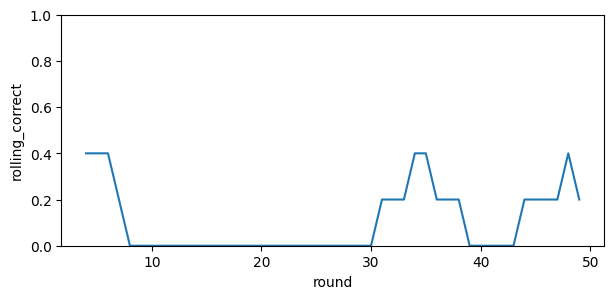

In [243]:
# plot rolling mean 

plt.figure(figsize=(7, 3))
sns.lineplot(data=df, x='round', y='rolling_correct')
plt.ylim(0, 1)
plt.show()

In [205]:
calculate_upper_bound(4, (3, 3))

4096